In [10]:
# Instalação
!pip install numpy scikit-learn matplotlib scikit-image tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Importações
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [12]:
# Função para carregar imagens
def carregar_imagens(dataset_dir, tipo): 
    X, y = [], []
    classes = sorted(os.listdir(dataset_dir))
    for classe in classes:
        caminho_classe = os.path.join(dataset_dir, classe, tipo)
        if not os.path.isdir(caminho_classe):
            continue
        for arquivo in os.listdir(caminho_classe):
            caminho_img = os.path.join(caminho_classe, arquivo)
            try:
                img = imread(caminho_img)
                # img = resize(img, (64, 64))
                img = resize(img, (128, 128))
                X.append(img)
                y.append(classe)
            except Exception as e:
                print(f"[ERRO] Imagem inválida: {caminho_img} ({e})")
    return np.array(X), np.array(y)

In [13]:
# Função para extração do HOG
def extrair_features_hog(X):
    features = []
    for img in tqdm(X, desc="Extraindo HOG"):
        img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        hog_feat = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        features.append(hog_feat)
    return np.array(features)

In [14]:
# Caminho do dataset
dataset_path = 'dataset'

# Carregar imagens
X_train, y_train = carregar_imagens(dataset_path, 'treinamento')
X_test, y_test = carregar_imagens(dataset_path, 'teste')

print("Imagens de treinamento:", len(X_train))
print("Imagens de teste:", len(X_test))

Imagens de treinamento: 1600
Imagens de teste: 400


In [15]:
# Codificar rótulos
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [16]:
# Extrair HOG
X_train_hog = extrair_features_hog(X_train)
X_test_hog = extrair_features_hog(X_test)


Extraindo HOG: 100%|██████████| 400/400 [00:01<00:00, 232.54it/s]


In [17]:
# Treinar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_hog, y_train_enc)

# Prever
y_pred = rf.predict(X_test_hog)

# Exibir relatório
print("Relatório de Classificação:")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred))
print(f"RMSE: {rmse:.4f}")


Relatório de Classificação:
              precision    recall  f1-score   support

       metal       0.52      0.51      0.52        80
       papel       0.60      0.61      0.61        80
     papelao       0.67      0.81      0.73        80
    plastico       0.49      0.50      0.50        80
       vidro       0.39      0.30      0.34        80

    accuracy                           0.55       400
   macro avg       0.53      0.55      0.54       400
weighted avg       0.53      0.55      0.54       400

RMSE: 1.6447


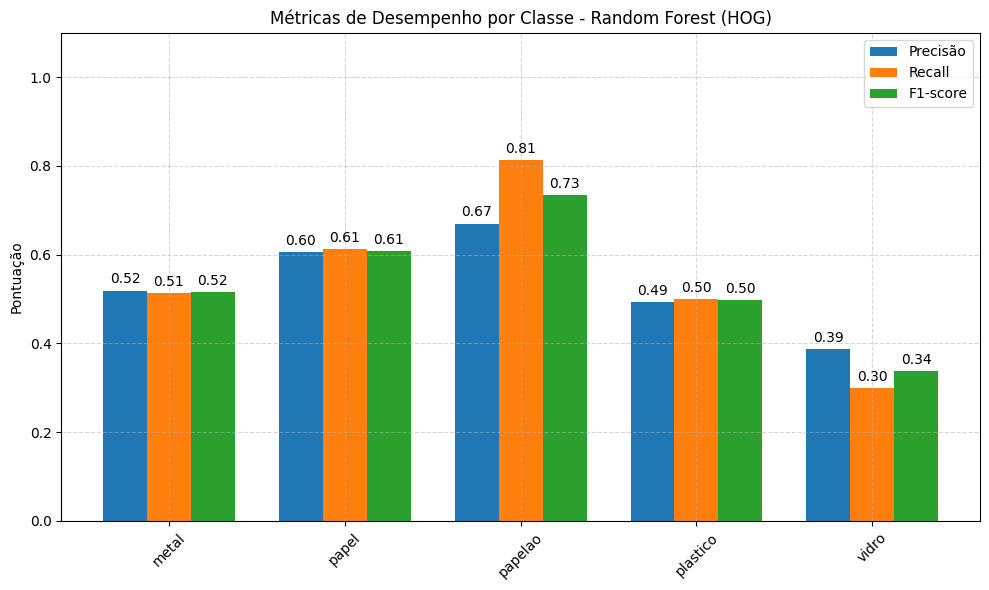

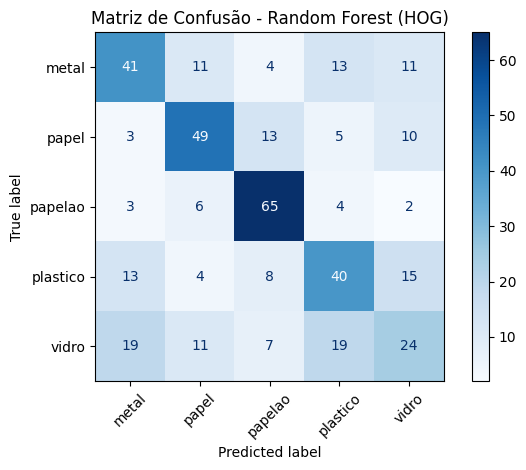

In [18]:
# Relatório como dicionário
report = classification_report(
    y_test_enc, y_pred,
    target_names=label_encoder.classes_,
    output_dict=True
)

# Extrair métricas
labels = list(label_encoder.classes_)
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

# Criar gráfico
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precisão')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-score')

# Estilização
ax.set_ylabel('Pontuação')
ax.set_ylim(0, 1.1)
ax.set_title('Métricas de Desempenho por Classe - Random Forest (HOG)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Exibir valores nos topos das barras
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão - Random Forest (HOG)")
plt.tight_layout()
plt.show()